**Тестовое задание в команду продуктовой аналитики, Gett.**  
Вариант решения от Аркадия (tg: @ArkadiyD)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.rc('axes', titlesize   = 15)
plt.rc('axes', titlepad    = 12)
plt.rc('axes', labelweight = 'bold')
plt.rc('font', size   = 13)

In [ ]:
df_offers = pd.read_csv('https://raw.githubusercontent.com/obulygin/test_tasks/master/data_analyst/Gett/data/data_offers.csv')
df_offers.head(3)
# номер заказа(order_gk) - ID оффера (offer_id), который был предложен водителю по данному заказу

,order_gk,offer_id
0,3000579625629,300050936206
1,3000627306450,300052064651
2,3000632920686,300052408812


In [ ]:
df_offers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 334363 entries, 0 to 334362
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype
---  ------    --------------   -----
 0   order_gk  334363 non-null  int64
 1   offer_id  334363 non-null  int64
dtypes: int64(2)
memory usage: 5.1 MB


In [ ]:
df_orders = pd.read_csv('https://raw.githubusercontent.com/obulygin/test_tasks/master/data_analyst/Gett/data/data_orders.csv')
df_orders.info()
# order_datetime   - время заказа
# origin_longitude - долгота
# origin_latitude  - широта
# m_order_eta      - время до прибытия машины
# order_gk         - номер заказа
# order_status_key - статус (4 - отменен клиентом, 9 - отменен системой (reject))
# is_driver_assigned_key        - был ли назначен водитель
# cancellations_time_in_seconds - сколько секунд прошло до отмены

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10716 entries, 0 to 10715
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   order_datetime                 10716 non-null  object 
 1   origin_longitude               10716 non-null  float64
 2   origin_latitude                10716 non-null  float64
 3   m_order_eta                    2814 non-null   float64
 4   order_gk                       10716 non-null  int64  
 5   order_status_key               10716 non-null  int64  
 6   is_driver_assigned_key         10716 non-null  int64  
 7   cancellations_time_in_seconds  7307 non-null   float64
dtypes: float64(4), int64(3), object(1)
memory usage: 669.9+ KB


в столбце "**m_order_eta**" очень много пропусков

In [ ]:
# изменим тип данных в столбце времени заказа:
df_orders.order_datetime    = pd.to_datetime(df_orders.order_datetime)
df_orders['hour']           = df_orders.order_datetime.dt.hour                   # добавили часы
df_orders['order_datetime'] = df_orders.order_datetime.dt.strftime('%H:%M:%S')
df_orders.head()

,order_datetime,origin_longitude,origin_latitude,m_order_eta,order_gk,order_status_key,is_driver_assigned_key,cancellations_time_in_seconds,hour
0,18:08:07,-0.978916,51.456173,60.0,3000583041974,4,1,198.0,18
1,20:57:32,-0.950385,51.456843,NaN,3000583116437,4,0,128.0,20
2,12:07:50,-0.969520,51.455544,477.0,3000582891479,4,1,46.0,12
3,13:50:20,-1.054671,51.460544,658.0,3000582941169,4,1,62.0,13
4,21:24:45,-0.967605,51.458236,NaN,3000583140877,9,0,NaN,21


---
**1.** Постройте распределение заказов по причинам неуспеха: отмены до и после назначения водителя, режекты

In [ ]:
df_orders.groupby(['order_status_key', 'is_driver_assigned_key'])['order_gk'].nunique()

order_status_key  is_driver_assigned_key
4                 0                         4496
                  1                         2811
9                 0                         3406
                  1                            3
Name: order_gk, dtype: int64

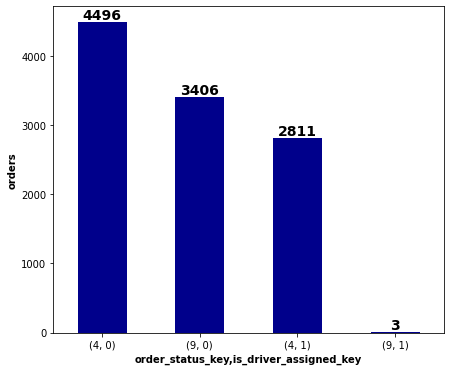

In [ ]:
plt.figure(figsize = (7,6))

df_grouped = df_orders.groupby(['order_status_key', 'is_driver_assigned_key'])['order_gk'].\
             nunique().sort_values(ascending = False)

df_grouped.plot(kind = 'bar', rot = 0, color = 'darkblue')

for i, val in enumerate(df_grouped.values):
    plt.text(i, val, int(val), horizontalalignment = 'center', verticalalignment = 'bottom', fontdict = {'size':14, 'weight': 'bold'})

plt.ylabel('orders')
plt.show()

# Наибольшее число заказов было отменено клиентом, когда еще не был назначен водитель.
# При этом всего ТРИ заказа отменила сама система, когда уже был назначен водитель.

**2.** Постройте график распределения фейлов по часам - наблюдается ли тендеция, что в какие то часы доля той или иной категории аномально высока?

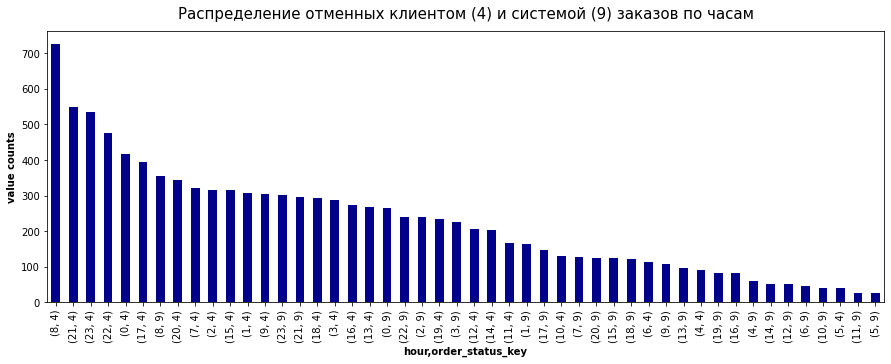

In [ ]:
plt.figure(figsize = (15,5))
df_orders.groupby(['hour'])['order_status_key'].value_counts().sort_values(ascending = False).plot(kind = 'bar', color = 'darkblue')
plt.title('Распределение отменных клиентом (4) и системой (9) заказов по часам')
plt.ylabel('value counts')
plt.show()

**Выводы:** В 8 часов утра клиент чаще всего отменял такси.
Также именно в 8 утра наибольшее число раз сама система отменяла заказы, причем делала она это в 2 раза реже, чем клиент за этот час.

Скорее всего, это связано из-за сильных утренних пробок на дорогах.
В вечернее время с 21 часа до полуночи активность клиентов, отменяющих заказы, также оставалась на высоком уровне.

Утром в 5 часов и клиент, и система реже всего отменяли заказы, видимо, из-за того, что самих заказов было мало в столь раннее время.

**3.** Постройте графики среднего времени до отмены (**cancellations_time_in_seconds**) с водителем и без, **по часам**. Если есть выбросы в данных - лучше удалить. Можно ли сделать выводы по этому графику?

In [ ]:
df_orders.loc[df_orders.cancellations_time_in_seconds.isna() == True].order_status_key.unique()

# Если мы уберем эти пропуски, то потеряем ВСЮ информацию по отмененным заказам со статусом 9 - reject.
# Иными словами, система вообще не указывала сколько секунд прошло до отмены заказа, когда она его отменяла.

array([9])

In [ ]:
print(f'median: {df_orders.cancellations_time_in_seconds.median()}')
print(f'mode:   {df_orders.cancellations_time_in_seconds.mode()[0]}')

median: 98.0
mode:   10.0


In [ ]:
# Заменим все пропуски модой, независящей от выбросов:
df_orders.cancellations_time_in_seconds.fillna(df_orders.cancellations_time_in_seconds.mode()[0], inplace = True)

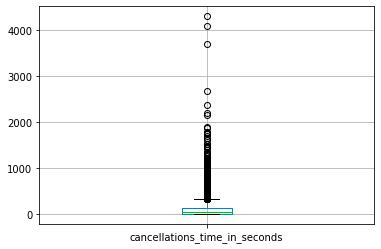

In [ ]:
# найдем выбросы по данным без пропусков:
df_orders[['cancellations_time_in_seconds']].boxplot()

In [ ]:
# удалим выбросы

q1  = df_orders.cancellations_time_in_seconds.quantile(0.25)
q3  = df_orders.cancellations_time_in_seconds.quantile(0.75)
iqr = q3 - q1  # межквартильный размах

lower_bound  = q1 - (1.5 * iqr) # нижняя граница диапазона
higher_bound = q3 + (1.5 * iqr) # верхняя граница диапазона

# датафрем без выбросов:
df = df_orders.loc[df_orders.cancellations_time_in_seconds.between(lower_bound, higher_bound, inclusive = 'both')]

print('Метрики ДО удаления выбросов:')
print(f'min:    {df_orders.cancellations_time_in_seconds.min()}')
print(f'max:    {df_orders.cancellations_time_in_seconds.max()}')
print(f'median: {df_orders.cancellations_time_in_seconds.median()}')
print(f'mode:   {df_orders.cancellations_time_in_seconds.mode()[0]}')
print(f'std:    {df_orders.cancellations_time_in_seconds.std()}')

print('\nМетрики ПОСЛЕ удаления выбросов:')
print(f'min:    {df.cancellations_time_in_seconds.min()}')
print(f'max:    {df.cancellations_time_in_seconds.max()}')
print(f'median: {df.cancellations_time_in_seconds.median()}')
print(f'mode:   {df.cancellations_time_in_seconds.mode()[0]}')
print(f'std:    {df.cancellations_time_in_seconds.std()}')

Метрики ДО удаления выбросов:
min:    3.0
max:    4303.0
median: 47.0
mode:   10.0
std:    189.17288077301794

Метрики ПОСЛЕ удаления выбросов:
min:    3.0
max:    332.0
median: 38.0
mode:   10.0
std:    76.07784889519371


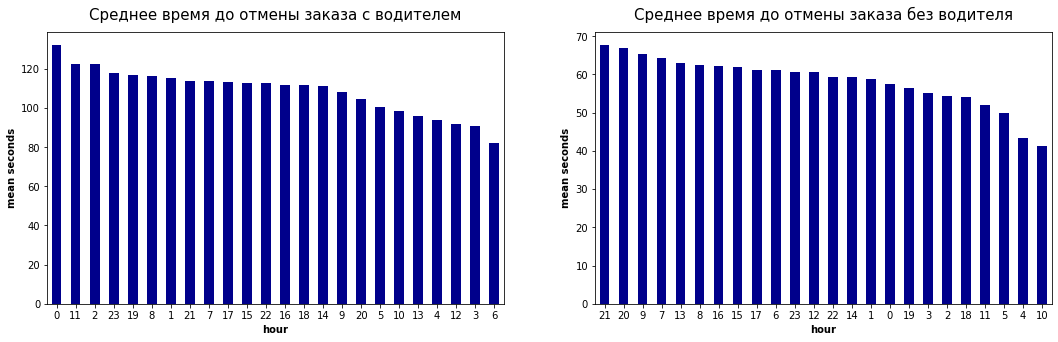

In [ ]:
# теперь визуализируем среднее время в секундах до отмены заказа с водителем и без, отдельно по часам

df_yes_driver = df.loc[df_orders.is_driver_assigned_key == 1]
df_no_driver  = df.loc[df_orders.is_driver_assigned_key == 0]

fig = plt.figure(figsize = (18, 5))

plt.subplot(121)
df_yes_driver.groupby('hour')['cancellations_time_in_seconds'].mean().sort_values(ascending = False).plot(kind = 'bar', rot = 0, color = 'darkblue')
plt.ylabel('mean seconds')
plt.title('Среднее время до отмены заказа с водителем')

plt.subplot(122)
df_no_driver.groupby('hour')['cancellations_time_in_seconds'].mean().sort_values(ascending = False).plot(kind = 'bar', rot = 0, color = 'darkblue')
plt.ylabel('mean seconds')
plt.title('Среднее время до отмены заказа без водителя')
plt.show()

Видим, что **вне зависимости** от времени суток **в среднем** времени до отмены заказа проходило **больше** для случая, когда был назначен водитель.

Наименьшее же среднее время до отмены заказа наблюдалось в 6 утра с водителем и 10 утра без водителя.

**4.** Постройте распределение **среднего ЕТА** по часам. Чем можно объяснить такой вид графика?

In [ ]:
round(df_orders.m_order_eta.isna().mean() * 100, 2) 

# более 73 % данных о времени до прибытия машины пропущено в этом столбце, поэтому замена пропусков под большим вопросом

73.74

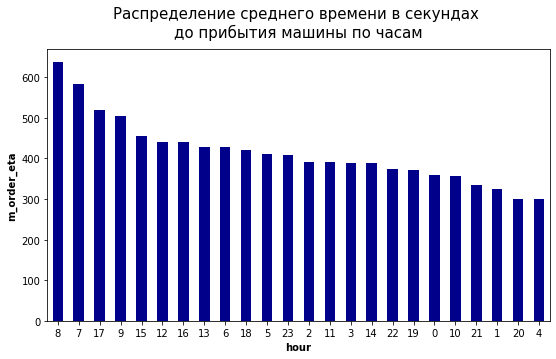

In [ ]:
plt.figure(figsize = (9, 5))
df_orders.groupby('hour')['m_order_eta'].mean().sort_values(ascending = False).plot(kind = 'bar', rot = 0, color = 'darkblue')
plt.title('Pаспределение среднего времени в секундах \nдо прибытия машины по часам')
plt.ylabel('m_order_eta')
plt.show()

Из-за того, что в утренние часы наблюдаются большие пробки на рабочей неделе, в 8 утра ждать такси пришлось дольше всего по времени. А в 4 утра, наоборот, такси приезжало быстрее всего на вызов из-за отсутствия каких-либо пробок на дорогах.

**5.** Колонка **drivers_offered** - показывает сколько водителей увидели заказ и могли его принять. Постройте часовую разбивку среднего количества водителей, которым был предложен заказ. Что можно сказать по ней про избыток/нехватку водителей в те или иные часы?

In [ ]:
# добавим информацию о ID оффера:
df_merge = df_orders.merge(df_offers, on = 'order_gk', how = 'left')

# получим датафрейм, показывающий сколько водителей увидели заказ и могли его принять в определенный час времени:
df_drivers_offered = df_merge.groupby(['order_gk', 'hour'])['offer_id'].nunique().reset_index().sort_values('offer_id', ascending = False)
df_drivers_offered.rename(columns = {'offer_id': 'drivers_offered'}, inplace = True)
df_drivers_offered

# на заказы, у которых drivers_offered = 0, не было вообще желающих/доступных водителей

,order_gk,hour,drivers_offered
9521,3000627506233,22,9
3486,3000585915504,2,9
5369,3000595047247,20,9
1298,3000558137039,22,9
3593,3000586391080,21,9
...,...,...,...
3607,3000586417013,23,0
3606,3000586416759,23,0
3605,3000586416729,22,0
3604,3000586391768,22,0


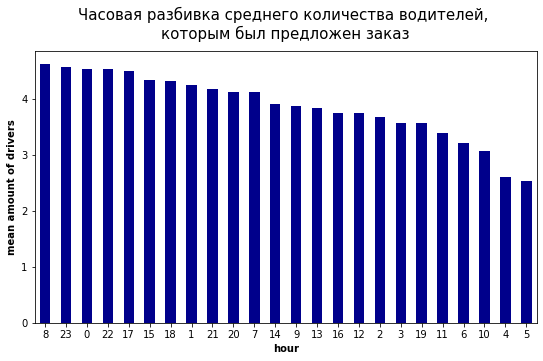

In [ ]:
plt.figure(figsize = (9, 5))
plt.title('Часовая разбивка среднего количества водителей, \nкоторым был предложен заказ')

df_drivers_offered.loc[df_drivers_offered.drivers_offered != 0].groupby('hour')\
['drivers_offered'].mean().sort_values(ascending = False).plot(kind = 'bar', rot = 0, color = 'darkblue')

plt.ylabel('mean amount of drivers')
plt.show()

Видим, что в 8 утра, когда людям надо было ехать на работу, и с 22 часов вечера до полуночи, в среднем наибольшему числу водителей было предложено заказов. Поэтому в это время может наблюдаться **нехватка** водителей из-за наплыва клиентов.

А в 4 часа и 5 часов утра, когда большинство людей обычно еще спят, наименьшему числу водителей было предложено заказов. Соответственно, может наблюдаться **избыток** водителей в столь раннее время.

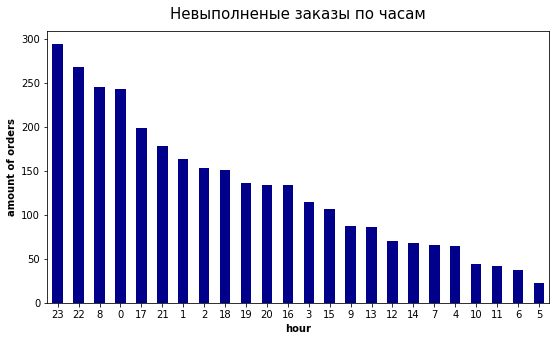

In [ ]:
# дополнительно выделим те заказы, которые водители не увидели и/или не могли их принять

plt.figure(figsize = (9, 5))
plt.title('Невыполненые заказы по часам')

df_drivers_offered.loc[df_drivers_offered.drivers_offered == 0].groupby('hour')\
['drivers_offered'].count().sort_values(ascending = False).plot(kind = 'bar', rot = 0, color = 'darkblue')

plt.ylabel('amount of orders')
plt.show()

Видим, что **ни один** из водителей не увидел (и/или не смог принять) наибольшее число заказов именно в те часы, когда у них был ажиотаж: в 8 утра и с 22 часов вечера до полуночи. 

Данное заключение дополняет вывод к рисунку выше по часовой разбивке среднего количества водителей, которым был предложен заказ.